# CNN Interpretation - Sensitive Area Detection

**Note**: This notebook is desinged to run on CPU (no GPU) runtime.

**[CIS-01]**

Install libraries.

In [1]:
%%bash
curl -sLO https://raw.githubusercontent.com/enakai00/colab_jaxbook/main/requirements.txt
pip install -qr requirements.txt
pip list | grep -E '(jax|flax|optax)'

flax                          0.6.1
jax                           0.3.21
jaxlib                        0.3.15+cuda11.cudnn805
optax                         0.1.3


**[CIS-02]**

Import modules.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from functools import partial
from tensorflow.keras.datasets import mnist

import jax, optax
from jax import grad, random, numpy as jnp
from flax import linen as nn
from flax.training import train_state, checkpoints
from flax.core.frozen_dict import freeze, unfreeze

plt.rcParams.update({'font.size': 12})

**[CIS-03]**

Download the MNIST dataset and store into NumPy arrays.

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape([-1, 784]).astype('float32') / 255
test_images = test_images.reshape([-1, 784]).astype('float32') / 255
train_labels = np.eye(10)[train_labels]
test_labels = np.eye(10)[test_labels]

11501568/11490434 [==============================] - 0s 0us/step


**[CIS-04]**

Mount Google Drive content.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**[CIS-05]**

Confirm that the checkpoint file is stored in the folder.

In [5]:
!ls -lh '/content/gdrive/My Drive/checkpoints/'

total 75M
-rw------- 1 root root 38M Oct  5 01:56 DoubleLayerCNN_checkpoint_16
-rw------- 1 root root 37M Oct  5 01:58 SingleLayerCNN_checkpoint_16


**[CIS-06]**

Restore parameter values from the checkpoint file.

In [6]:
state_dict = checkpoints.restore_checkpoint(
    ckpt_dir='/content/gdrive/My Drive/checkpoints/',
    prefix='DoubleLayerCNN_checkpoint_',
    target=None)

restored_params = state_dict['params']

jax.tree_util.tree_map(lambda x: x.shape, restored_params)

{'Conv_0': {'bias': (32,), 'kernel': (5, 5, 1, 32)},
 'Conv_1': {'bias': (64,), 'kernel': (5, 5, 32, 64)},
 'Dense_0': {'bias': (1024,), 'kernel': (3136, 1024)},
 'Dense_1': {'bias': (10,), 'kernel': (1024, 10)}}

**[CIS-07]**

Define a CNN model consisted of the first and second blocks.

In [7]:
class DoubleLayerCNN2(nn.Module):
    def setup(self):
        self.first_block = FirstBlock()
        self.second_block = SecondBlock()

    @nn.compact
    def __call__(self, x):
        x = self.first_block(x)
        x = self.second_block(x)
        return x
        

class FirstBlock(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = x.reshape([-1, 28, 28, 1])

        x = nn.Conv(features=32, kernel_size=(5, 5))(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = nn.Conv(features=64, kernel_size=(5, 5))(x)
        x = nn.relu(x)
        return x


class SecondBlock(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape([x.shape[0], -1])  # flatten
        x = nn.Dense(features=1024)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        x = nn.softmax(x)
        return x

**[CIS-08]**

Generate initial parameter values and check the structure.

In [8]:
variables = DoubleLayerCNN2().init(random.PRNGKey(0), jnp.zeros([1, 28*28]))

jax.tree_util.tree_map(lambda x: x.shape, variables['params'])

FrozenDict({
    first_block: {
        Conv_0: {
            bias: (32,),
            kernel: (5, 5, 1, 32),
        },
        Conv_1: {
            bias: (64,),
            kernel: (5, 5, 32, 64),
        },
    },
    second_block: {
        Dense_0: {
            bias: (1024,),
            kernel: (3136, 1024),
        },
        Dense_1: {
            bias: (10,),
            kernel: (1024, 10),
        },
    },
})

**[CIS-09]**

Copy parameter values from `restored_params`.

In [9]:
new_params = unfreeze(variables['params'])
new_params['first_block']['Conv_0'] = restored_params['Conv_0']
new_params['first_block']['Conv_1'] = restored_params['Conv_1']
new_params['second_block']['Dense_0'] = restored_params['Dense_0']
new_params['second_block']['Dense_1'] = restored_params['Dense_1']
new_params = freeze(new_params)

state = train_state.TrainState.create(
    apply_fn=DoubleLayerCNN2().apply,
    params=new_params,
    tx=optax.adam(learning_rate=0.001))

**[CIS-10]**

Define a function to get the max prediction value.

In [10]:
def max_prediction(filter_output):
    predictions = state.apply_fn(
        {'params': state.params}, jnp.asarray([filter_output]),
        method=lambda m, x :m.second_block(x))
    return jnp.max(predictions)

**[CIS-11]**

Define a function to create a heatmap for sensitive areas.

In [11]:
def create_heatmap(state, image):
    filter_outputs = state.apply_fn(
        {'params': state.params}, jnp.asarray([image]),
        method=lambda m, x :m.first_block(x))
    filter_output = filter_outputs[0]
    # filter_outputs.shape = (14, 14, 64)
    
    filter_grads = jax.grad(max_prediction)(filter_output)
    # filter_grads.shape = (14, 14, 64)

    num_filters = filter_grads.shape[-1]
    weight = np.zeros(num_filters)
    for i in range(num_filters):
        weight[i] = max(0, jnp.mean(filter_grads[:, :, i]))

    heatmap_image = np.zeros([14, 14])
    for i in range(num_filters):
        heatmap_image += filter_output[:, :, i] * weight[i]
    heatmap_image /= np.max(heatmap_image)

    return heatmap_image

**[CIS-12]**

Create and show heatmaps.

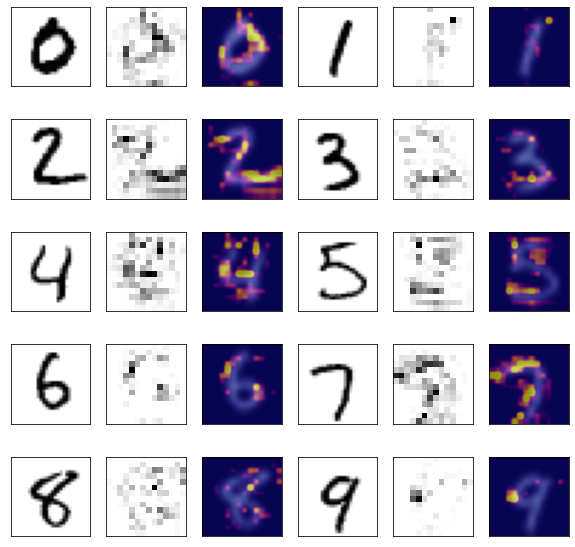

In [12]:
fig = plt.figure(figsize=(10, 10))
i = 1
for image in test_images[[3, 5, 1, 32, 4, 15, 21, 254, 84, 12]]:
    heatmap = create_heatmap(state, image)

    subplot = fig.add_subplot(5, 6, i)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(image.reshape([28, 28]), vmin=0, vmax=1, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(5, 6, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(heatmap, vmin=0, vmax=1, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(5, 6, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(heatmap, vmin=0.1, vmax=0.6, 
                   cmap=plt.cm.plasma, interpolation='hanning')
    mat = image.reshape([28, 28])
    M, N = mat.shape[0] // 2, mat.shape[1] // 2
    mat = mat[:M*2, :N*2].reshape(M, 2, N, 2).mean(axis=(1, 3))
    _ = subplot.imshow(mat, alpha=0.4, 
                       cmap=plt.cm.bone, interpolation='bicubic')
  
    i += 3